In [1]:
import load_data
import numpy as np
import gc
from matplotlib import pyplot as plt
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Dropout, SimpleRNN
from keras.models import Sequential
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time.time()))

In [16]:
def convert_from_one_hot(mat_2d):
    mat_1d = []
    for i in mat_2d:
        arg = np.argmax(i) + 1
        mat_1d.append(arg)
        
    return mat_1d

In [17]:
def check_class_imbalance(train_labels, test_labels):
    
    tr_lbl_dict = dict()
    for i in range(len(train_labels)):
        if(train_labels[i] in tr_lbl_dict):
            tr_lbl_dict[train_labels[i]] += 1
        else:
            tr_lbl_dict[train_labels[i]] = 1

    print("Train Labels Distribution")
    print(tr_lbl_dict)

    print()

    ts_lbl_dict = dict()
    for i in range(len(test_labels)):
        if(test_labels[i] in ts_lbl_dict):
            ts_lbl_dict[test_labels[i]] += 1
        else:
            ts_lbl_dict[test_labels[i]] = 1

    print("Test Labels Distribution")
    print(ts_lbl_dict)

In [2]:
def make_pca_features(trainx, testx, p=180):

    start = time.time()
    
    pca = PCA(n_components=p)

    x_train_pca = pca.fit_transform(trainx)
    x_test_pca = pca.transform(testx)
    
    stop = time.time()
    
    elapsed = round(stop - start, 3)
    
    print()
    print("Time taken for PCA feature selection : {}s".format(elapsed))
    print()
    
    return x_train_pca, x_test_pca

In [3]:
def make_mms_scaled_features(trainx, testx, x_train_pca, x_test_pca):

    start = time.time()
    
    minmaxscaler = MinMaxScaler()

    xtr_scaled_mms = minmaxscaler.fit_transform(trainx)
    xts_scaled_mms = minmaxscaler.fit_transform(testx)

    xtr_scaled_mms_pca = minmaxscaler.fit_transform(x_train_pca)
    xts_scaled_mms_pca = minmaxscaler.fit_transform(x_test_pca)
    
    stop = time.time()
    
    elapsed = round(stop - start, 3)
    
    print()
    print("Time taken for Min-Max feature scaling : {}s".format(elapsed))
    print()

    return xtr_scaled_mms, xts_scaled_mms, xtr_scaled_mms_pca, xts_scaled_mms_pca

In [4]:
def make_std_scaled_features(trainx, testx, x_train_pca, x_test_pca):

    start = time.time()
    
    stdscaler = StandardScaler()

    xtr_scaled_std = stdscaler.fit_transform(trainx)
    xts_scaled_std = stdscaler.fit_transform(testx)

    xtr_scaled_std_pca = stdscaler.fit_transform(x_train_pca)
    xts_scaled_std_pca = stdscaler.fit_transform(x_test_pca)
    
    stop = time.time()
    
    elapsed = round(stop - start, 3)
    
    print()
    print("Time taken for Standard feature scaling : {}s".format(elapsed))
    print()
    
    return xtr_scaled_std, xts_scaled_std, xtr_scaled_std_pca, xts_scaled_std_pca

In [21]:
def trainELM(in_data, out_data):
        
    elm_input = in_data
    elm_output = out_data
    in_shape = in_data.shape[1]

    elm_hidden_nodes = 1000

    A = np.random.random((in_shape, elm_hidden_nodes))

    H = np.dot(elm_input, A)

    # H = sigmoid(H)

    Hinv = np.linalg.pinv(H)

    B = np.dot(Hinv, elm_output)

    pred_output = np.dot(H, B)

    pred = convert_from_one_hot(pred_output)

    actual = convert_from_one_hot(elm_output)

    corr = 0
    total = 0

    for i in range(len(actual)):
        total += 1
        if(pred[i] == actual[i]):
            corr += 1

    return A, B

In [22]:
def testELM(in_data, out_data, A, B):
    
    elm_hidden_nodes = 1000
    elm_input = in_data
    elm_output = out_data
    in_shape = in_data.shape[1]
    
    testH = np.dot(elm_input, A)
    
    test_pred = np.dot(testH, B)
    
    pred = convert_from_one_hot(test_pred)

    actual = convert_from_one_hot(elm_output)

    corr = 0
    total = 0

    for i in range(len(actual)):
        total += 1
        if(pred[i] == actual[i]):
            corr += 1
            
    test_acc = round(((corr/total) * 100), 2)

    print("Classification accuracy (L = {}): {}%".format(elm_hidden_nodes, test_acc))
    
    return test_acc

In [23]:
def calculate_elm_performance(xtr_scaled_std_pca, trainy, xts_scaled_std_pca, testy):

    all_acc_elm = []
    all_times_elm = []

    for i in range(3):

        print()
        print()
        print("Iteration {}".format(i+1))
        print()
        
        start_time = time.time()

        a, beta = trainELM(xtr_scaled_std_pca, trainy)

        # stop_time = time.time()

        # print("Time elapsed (Training): {} sec\n".format(round(elapsed_time, 2)))

        # start_time = time.time()

        # #
        # Testing Phase
        # #

        test_acc = testELM(xts_scaled_std_pca, testy, a, beta)

        all_acc_elm.append(test_acc)

        stop_time = time.time()

        elapsed_time = round((stop_time - start_time), 3)
        
        all_times_elm.append(elapsed_time)

        # #
        # Training Auto-ELM
        # #

        print("Time elapsed (Testing): {} sec\n".format(elapsed_time))

    print()
    print()
    print("Average Testing Accuracy (ELM) : {}%".format(np.average(all_acc_elm)))
    
    return all_acc_elm, all_times_elm

In [42]:
def calculate_rf_performance(xtr_scaled_std_pca, y_train, xts_scaled_std_pca, y_test):
    
    all_acc_rf = []
    all_times_rf = []
    
    for i in range(3):
        
        print("Iteration {}".format(i+1))
        
        start = time.time()
        
        rfc = RandomForestClassifier(n_estimators=200, max_depth=5000, n_jobs=-1, verbose=0)

        rfc.fit(xtr_scaled_std_pca, y_train)

        tsacc = round(rfc.score(xts_scaled_std_pca, y_test) * 100, 2)
        print("Testing Accuracy : %".format(tsacc))
        
        stop = time.time()
        
        elapsed = round((stop - start), 3)
        
        all_times_rf.append(elapsed)
        all_acc_rf.append(tsacc)
    
    print()
    print("Average Testing Accuracy (RF) : {}%".format(np.average(all_acc_rf)))
    
    return all_acc_rf, all_times_rf

In [25]:
def lr_scheduler(epoch):
    if(epoch <= 5):
        return 1e-3
    elif(epoch <= 10):
        return 1e-4
    elif(epoch <= 15):
        return 1e-5
    else:
        return 1e-6
    return 1e-6

In [26]:
def make_labels_for_sparse(y_train, y_test):

    train_labels = y_train
    test_labels = y_test

    le = LabelEncoder()
    y_tr0 = le.fit_transform(y_train)
    y_ts0 = le.fit_transform(y_test)

    y_tr = np.reshape(y_tr0, ((len(y_tr0), 1)))
    y_ts = np.reshape(y_ts0, ((len(y_ts0), 1)))
    
    return y_tr, y_ts

In [27]:
def calculate_nn_performance(x_train_pca, y_tr, x_test_pca, y_ts):
    
    model = Sequential()

    model.add(Dense(1024, name='dense_input', input_shape=(180,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # model.add(Dense(256, name='dense2'))
    # model.add(Activation('relu'))
    # model.add(Dropout(0.5))

    model.add(Dense(3, name='classifier'))
    model.add(Activation('softmax'))

    print(model.summary())
    print()

    all_acc_nn = []
    all_times_nn = []

    for i in range(3):
        
        start = time.time()
        print()
        print("Iteration {}".format(i+1))
        print()
        model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['acc'])
        keras.callbacks.LearningRateScheduler(lr_scheduler)
        m_h = model.fit(x_train_pca, y_tr, epochs=20, batch_size=2048, validation_data=(x_test_pca, y_ts), callbacks=[tensorboard])
        print()
        acc = round(np.average(m_h.history['val_acc']) * 100, 2)
        print("Testing Accuracy : {}%".format(acc))
        stop = time.time()
        elapsed_time = round(stop-start, 3)
        all_acc_nn.append(acc)
        all_times_nn.append(elapsed_time)
        print()
        print("Time elapsed : {}s".format(elapsed_time))
        print()
        print()

    print()
    print()
    print("Average Testing Accuracy (NN) : {}%".format(np.average(all_acc_nn)))

    return all_acc_nn, all_times_nn

In [28]:
def calculate_svm_performance(x_train_pca, y_train, x_test_pca, y_test):

    all_acc_svm = []
    all_times_svm = []

    for i in range(3):

        start_itr = time.time()

        print()
        print("Iteration {}".format(i+1))
        print()

        svm_model = SVC(C=0.2, verbose=2, gamma='auto')
    #     lsvm_model = LinearSVC(C=c)

        print("Fitting SVM model")

        svm_model.fit(x_train_pca, y_train)

        print("SVM model fitted")
    #     lsvm_model.fit(x_train, y_train)

    #     print()
    #     print("Linear SVM ( C = {} )".format(c))
    #     print("Training Accuracy : {}%".format(round((lsvm_model.score(x_train, y_train)) * 100, 2)))
    #     print("Testing Accuracy : {}%".format(round((lsvm_model.score(x_test, y_test)) * 100, 2)))

        print()
        tracc = round((svm_model.score(x_train_pca, y_train)) * 100, 2)
        tsacc = round((svm_model.score(x_test_pca, y_test)) * 100, 2)
        print("Training Accuracy : {}%".format(tracc))
        print("Testing Accuracy : {}%".format(tsacc))

        all_acc_svm.append(tsacc)

        stop_itr = time.time()
        
        iter_time = round((stop_itr - start_itr), 3)
        all_times_svm.append(iter_time)

        print()
        print("Iteration Time : {}s".format(iter_time))


    print()
    print()
    print("Average Testing Accuracy (SVM) : {}%".format(round(np.average(all_acc_svm), 2)))
    
    return all_acc_svm, all_times_svm

In [29]:
dataset = load_data.read_data_sets(one_hot=True)

In [30]:
trainx = dataset.train.data
trainy = dataset.train.labels

testx = dataset.test.data
testy = dataset.test.labels

y_train = convert_from_one_hot(trainy)
y_test = convert_from_one_hot(testy)

y_tr, y_ts = make_labels_for_sparse(y_train, y_test)

In [32]:
print("="*30)
print("Class Distribution")
print("-"*30)
check_class_imbalance(y_train, y_test)
print("="*30)
print()
print()

print("="*30)
print("Select PCA features (P=180)")
print("-"*30)
x_train_pca, x_test_pca = make_pca_features(trainx, testx)
print("Done")
print("="*30)
print()
print()
print("="*30)
print("Scaling Features using MinMaxScaler")
print("-"*30)
xtr_scaled_mms, xts_scaled_mms, xtr_scaled_mms_pca, xts_scaled_mms_pca = make_mms_scaled_features(trainx, testx, x_train_pca, x_test_pca)
print("Done")
print("="*30)
print()
print()
print("="*30)
print("Scaling Features using StdScaler")
print("-"*30)
xtr_scaled_std, xts_scaled_std, xtr_scaled_std_pca, xts_scaled_std_pca = make_std_scaled_features(trainx, testx, x_train_pca, x_test_pca)
print("Done")
print("="*30)
print()
print()
print("="*80)
print("\t\tExtreme Learning Machine (ELM) Performance")
print("-"*80)
all_acc_elm, all_times_elm = calculate_elm_performance(xtr_scaled_std_pca, trainy, xts_scaled_std_pca, testy)
print("="*80)
print()
print()
print("="*80)
print("\t\tNeural Network (NN) Performance")
print("-"*80)
all_acc_nn, all_times_nn = calculate_nn_performance(x_train_pca, y_tr, x_test_pca, y_ts)
print("="*80)
print()
print()
print("="*80)
print("\t\tSupport Vector Machine (SVM) Performance")
print("-"*80)
all_acc_svm, all_times_svm = calculate_svm_performance(x_train_pca, y_train, x_test_pca, y_test)
print("="*80)
print()
print()
print("="*80)
print("\t\tRandom Forest (RF) Performance")
print("-"*80)
all_acc_rf, all_times_rf = calculate_rf_performance(xtr_scaled_std_pca, y_train, xts_scaled_std_pca, y_test)
print("="*80)
print()
print()
print()
print()
print("All Evaluations Done!")
print()

Class Distribution
------------------------------
Train Labels Distribution
{1: 28602, 2: 26628, 3: 29190}

Test Labels Distribution
{1: 18438, 2: 19740, 3: 19950}


Select PCA features (P=180)
------------------------------
Done


Scaling Features using MinMaxScaler
------------------------------
Done


Scaling Features using StdScaler
------------------------------
Done


		Extreme Learning Machine (ELM) Performance
--------------------------------------------------------------------------------


Iteration 1

Classification accuracy (L = 1000): 71.73%
Time elapsed (Testing): 12.064 sec



Iteration 2

Classification accuracy (L = 1000): 71.73%
Time elapsed (Testing): 12.277 sec



Iteration 3

Classification accuracy (L = 1000): 71.73%
Time elapsed (Testing): 11.777 sec



Average Testing Accuracy (ELM) : 71.73%


		Neural Network (NN) Performance
--------------------------------------------------------------------------------
Model: "sequential_2"
__________________________________

In [45]:
print("="*40)
print("\tELM Performance")
print("-"*40)
for i in range(3):
    print('Iteration {}'.format(i+1))
    print("\tAverage Accuracy : {}%".format(all_acc_elm[i]))
    print("\tAverage Time : {} secs".format(all_times_elm[i]))
    print()
    print()
print("="*40)

print()
print()

print("="*40)
print("\tNeural Network Performance")
print("-"*40)
for i in range(3):
    print('Iteration {}'.format(i+1))
    print("\tAverage Accuracy : {}%".format(all_acc_nn[i]))
    print("\tAverage Time : {} secs".format(all_times_nn[i]))
    print()
    print()
print("="*40)

print()
print()

print("="*40)
print("\tSVM Performance")
print("-"*40)
for i in range(3):
    print('Iteration {}'.format(i+1))
    print("\tAverage Accuracy : {}%".format(all_acc_svm[i]))
    print("\tAverage Time : {} secs".format(all_times_svm[i]))
    print()
    print()
print("="*40)

print()
print()

print("="*40)
print("\tRF Performance")
print("-"*40)
for i in range(3):
    all_acc_rf[i] = round(all_acc_rf[i], 2)
    print('Iteration {}'.format(i+1))
    print("\tAverage Accuracy : {}%".format(all_acc_rf[i]))
    print("\tAverage Time : {} secs".format(all_times_rf[i]))
    print()
    print()
print("="*40)

	ELM Performance
----------------------------------------
Iteration 1
	Average Accuracy : 71.73%
	Average Time : 12.064 secs


Iteration 2
	Average Accuracy : 71.73%
	Average Time : 12.277 secs


Iteration 3
	Average Accuracy : 71.73%
	Average Time : 11.777 secs




	Neural Network Performance
----------------------------------------
Iteration 1
	Average Accuracy : 77.9%
	Average Time : 60.945 secs


Iteration 2
	Average Accuracy : 77.27%
	Average Time : 61.562 secs


Iteration 3
	Average Accuracy : 76.83%
	Average Time : 60.05 secs




	SVM Performance
----------------------------------------
Iteration 1
	Average Accuracy : 81.08%
	Average Time : 704.127 secs


Iteration 2
	Average Accuracy : 81.08%
	Average Time : 702.285 secs


Iteration 3
	Average Accuracy : 81.08%
	Average Time : 703.063 secs




	RF Performance
----------------------------------------
Iteration 1
	Average Accuracy : 77.79%
	Average Time : 22.563 secs


Iteration 2
	Average Accuracy : 77.8%
	Average Time : 22.254 

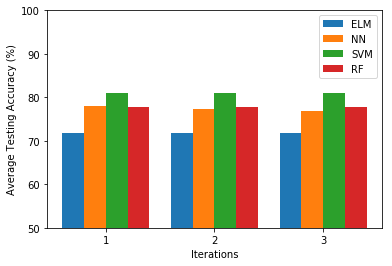

In [55]:
iterations = np.arange(3, step=1) + 1

ax = plt.subplot(111)

ax.bar(iterations-0.3, all_acc_elm, width=0.2, label='ELM')
ax.bar(iterations-0.1, all_acc_nn, width=0.2, label='NN')
ax.bar(iterations+0.1, all_acc_svm, width=0.2, label='SVM')
ax.bar(iterations+0.3, all_acc_rf, width=0.2, label='RF')

plt.ylim(50, 100)
plt.xticks(np.arange(3) + 1, )
plt.xlabel('Iterations')
plt.ylabel('Average Testing Accuracy (%)')
plt.legend(loc='upper right')

plt.show()

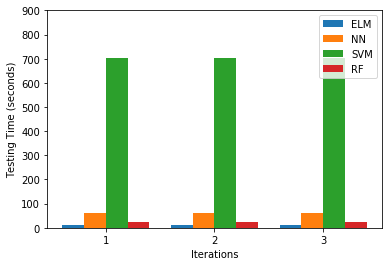

In [62]:
iterations = np.arange(3, step=1) + 1

ax = plt.subplot(111)

ax.bar(iterations-0.3, all_times_elm, width=0.2, label='ELM')
ax.bar(iterations-0.1, all_times_nn, width=0.2, label='NN')
ax.bar(iterations+0.1, all_times_svm, width=0.2, label='SVM')
ax.bar(iterations+0.3, all_times_rf, width=0.2, label='RF')

# plt.plot(iterations, all_acc_elm, 'or-', label='ELM')
# plt.plot(iterations, all_acc_nn, 'og-', label='NN')
# plt.plot(iterations, all_acc_svm, 'ob-', label='SVM')
plt.ylim(0, 900)
plt.xticks(np.arange(3) + 1,)
plt.xlabel('Iterations')
plt.ylabel('Testing Time (seconds)')
plt.legend(loc='upper right')

plt.show()

In [57]:
print("="*50)
print("\t\tBest Results")
print("-"*50)
print("Average Testing Accuracy : {}% (SVM)".format(max(all_acc_svm)))
print("-"*50)
print("Average Testing Time (for SVM) : {} secs".format(round(np.average(all_times_svm), 3)))
print("="*50)

		Best Results
--------------------------------------------------
Average Testing Accuracy : 81.08% (SVM)
--------------------------------------------------
Average Testing Time (for SVM) : 703.158 secs


In [64]:
print("="*50)
print("\t\tAll Average Results")
print("-"*50)
print("Testing Accuracy (ELM) : {}%".format(round(np.average(all_acc_elm), 2)))
print()
print("Testing Time (ELM) : {} secs".format(round(np.average(all_times_elm), 3)))
print("-"*50)
print("Testing Accuracy (NN) : {}%".format(round(np.average(all_acc_nn), 2)))
print()
print("Testing Time (NN) : {} secs".format(round(np.average(all_times_nn), 3)))
print("-"*50)
print("Testing Accuracy (SVM) : {}%".format(round(np.average(all_acc_svm), 2)))
print()
print("Testing Time (SVM) : {} secs".format(round(np.average(all_times_svm), 3)))
print("-"*50)
print("Testing Accuracy (RF) : {}%".format(round(np.average(all_acc_rf), 2)))
print()
print("Testing Time (RF) : {} secs".format(round(np.average(all_times_rf), 3)))
print("-"*50)
print("="*50)

		All Average Results
--------------------------------------------------
Testing Accuracy (ELM) : 71.73%

Testing Time (ELM) : 12.039 secs
--------------------------------------------------
Testing Accuracy (NN) : 77.33%

Testing Time (NN) : 60.852 secs
--------------------------------------------------
Testing Accuracy (SVM) : 81.08%

Testing Time (SVM) : 703.158 secs
--------------------------------------------------
Testing Accuracy (RF) : 77.76%

Testing Time (RF) : 22.389 secs
--------------------------------------------------
